In this projects, I will build several classfic CNN architecture from scrath, include Vision Transformer. Here are the list:
* [VGG](#VGG)
* [Res Net](#ResNet)
* [Efficient Net](#EfficientNet)
* [Mobile Net](#MobileNet)
* [Google Net](#GoogleNet)
* [Dense Net](#DenseNet)


What I have learn through this project:
* How to build a complext CNN model
* What is the strength of different CNN architecture 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import numpy as np

from tqdm.notebook import tqdm, trange
import time 
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Prepare DataLoader and training process

## Dataloader

In [3]:
DATA_PATH = "./data"
BATCH_SIZE = 128
N_EPOCHS = 50

In [4]:
test_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset =  datasets.CIFAR10(
    root=DATA_PATH, 
    train=True, 
    download=True, 
    transform=test_transforms
)

test_dataset = datasets.CIFAR10(
    root=DATA_PATH, 
    train=False, 
    download=True, 
    transform=test_transforms
)

print(f"Train Sample Size: {train_dataset.data.shape}")
print(f"Test Sample Size: {test_dataset.data.shape}")


train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2
)

100%|██████████| 170498071/170498071 [00:10<00:00, 15787061.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Sample Size: (50000, 32, 32, 3)
Test Sample Size: (10000, 32, 32, 3)


## Helper functions
some helper functions to train and evaluate model, and plot loss and metric

In [5]:
def train_one_epoch(
    model, 
    optimizer, 
    data_loader, 
    criterion, 
    metrics, 
    device
):
    """ 
    Train a model with single epoch, and return the metrics per epoch,  
    metrics include:
        - loss 
        - accuracy
    """
    print("Training...")
    summ = []
    
    model.train()
    with tqdm(total=len(data_loader)) as t:
        for i, (X_train, y_train) in enumerate(data_loader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_pred = y_pred.data.cpu().numpy()
            y_train = y_train.data.cpu().numpy()
            
            summary_batch = {
                metric: metrics[metric](y_pred, y_train) for metric in metrics
            }
            
            summary_batch['loss'] = loss.item()
            
            summ.append(summary_batch)
        
            t.set_postfix(accuracy = "{:05.3f}".format(summary_batch['accuracy']), loss="{:05.3f}".format(loss.item()))
            t.update()

    metrics_mean = {
        metric: np.mean([x[metric] for x in summ]) for metric in summ[0]
    }
    
    return metrics_mean

In [6]:
def evaluate(model, data_loader, criterion, metrics, device):
    print("Evaluating...")
    model.eval()
    
    summ = []
    with tqdm(total=len(data_loader)) as t:
        for i, (X_test, y_test) in enumerate(data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_pred = model(X_test)
            loss = criterion(y_pred, y_test)


            y_pred = y_pred.data.cpu().numpy()
            y_test = y_test.data.cpu().numpy()

            summary_batch = {
                metric: metrics[metric](y_pred, y_test) for metric in metrics
            }
            summary_batch['loss'] = loss.item()

            summ.append(summary_batch)

            t.set_postfix(accuracy = "{:05.3f}".format(summary_batch['accuracy']), loss="{:05.3f}".format(loss.item()))
            t.update()
    
    metrics_mean = {
        metric: np.mean([x[metric] for x in summ]) for metric in summ[0]
    }

    return metrics_mean

In [7]:
def train(
    model, 
    train_dataloader, 
    test_dataloader, 
    optimizer, 
    criterion, 
    metrics, 
    num_epochs, 
    device,
    scheduler = None,
):

    summ = {'train': {}, 'val': {}}
    best_val_acc = 0.0 
    
    model.to(device)

    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} / {num_epochs}")
        train_metrics = train_one_epoch(
            model = model,
            data_loader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            metrics=metrics,
            device = device,
        )
        eval_metrics = evaluate(
            model=model,
            data_loader=test_dataloader,
            criterion=criterion,
            metrics=metrics,
            device = device
        )
        summ['train'][epoch + 1] =  train_metrics
        summ['val'][epoch + 1] =  eval_metrics
        if scheduler:
            scheduler.step()
    
    return summ

In [8]:
def accuracy(outputs, labels):
    """ 
    outputs size: (B, 10) 10 is the number of classes
    labels size: (B, )
    """
    # (B, 10) -> (B, )
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs == labels) / float(labels.size)

metrics = {
    "accuracy": accuracy
}

In [9]:
def plot_one_model_summ(data):
    """ 
    summ is like: 
    {
        "train": {
            1: {"accuracy": ,"loss": }
        }
    }
    """
    # Extracting values for plotting
    epochs = list(data['train'].keys())
    train_accuracy = [data['train'][epoch]['accuracy'] for epoch in epochs]
    val_accuracy = [data['val'][epoch]['accuracy'] for epoch in epochs]
    train_loss = [data['train'][epoch]['loss'] for epoch in epochs]
    val_loss = [data['val'][epoch]['loss'] for epoch in epochs]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def train_model(model: nn.Module, EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), 
        lr=0.1,
        momentum=0.9, 
        weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    start_time = time.time()
    
    summ = train(
        model = model,
        criterion = criterion, 
        optimizer = optimizer,
        train_dataloader = train_dataloader,
        test_dataloader = test_dataloader, 
        num_epochs = EPOCHS,
        metrics = metrics,
        device = device,
        scheduler = scheduler
    )
    total_time = (time.time() - start_time)
    
    print("Total time to train model: {:.2f}s".format(total_time))
    print(f"Final accuracy on train datasets: {summ['train'][EPOCHS]['accuracy']}")
    print(f"Final accuracy on test datasets: {summ['val'][EPOCHS]['accuracy']}")
    
    plot_one_model_summ(summ)


Epoch 1 / 2
Training...


  0%|          | 0/391 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Evaluating...


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 / 2
Training...


  0%|          | 0/391 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/79 [00:00<?, ?it/s]

Total time to train model: 22.67s
Final accuracy on train datasets: 0.10003596547314579
Final accuracy on test datasets: 0.10027689873417721


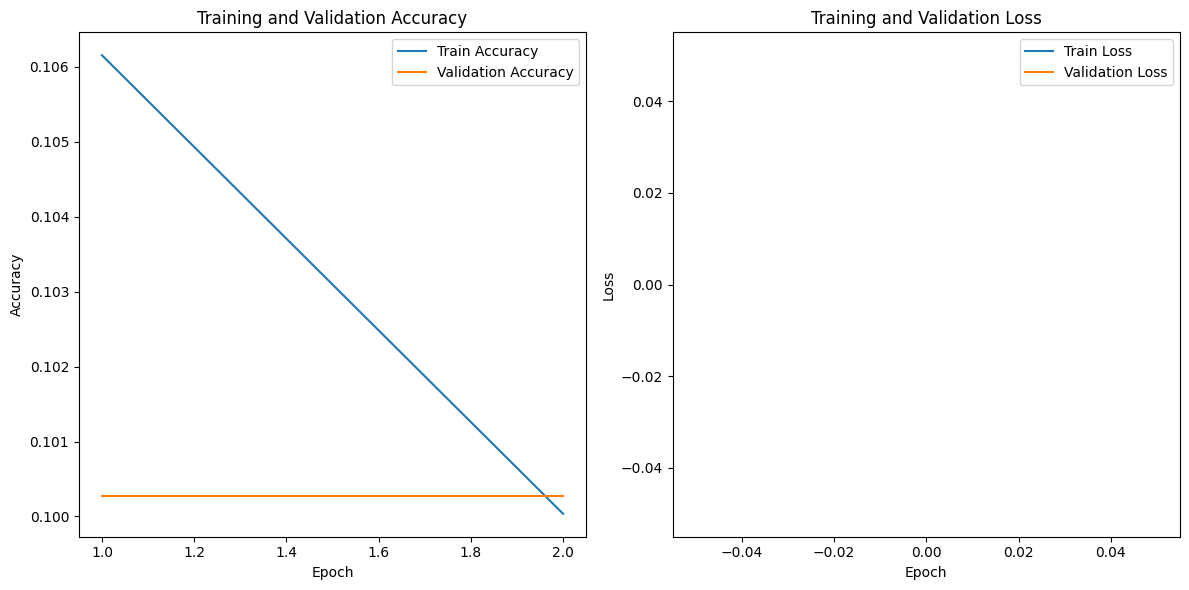

In [11]:
# Test above functions 

class mlp(nn.Module):
    def __init__(
        self,
        input_size = 3*32*32,
        output_size = 10,
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        batches = x.shape[0]
        x = x.view(batches, -1) # flatten
        out = self.layers(x)
        return F.log_softmax(out, dim=-1)
    
model = mlp()
train_model(model, 2)

# VGG

In [116]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [123]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super().__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                         ]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size = 1, stride=1)]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        # Flatten
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out 

In [125]:
def test():
    net = VGG('VGG11')
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

test()

torch.Size([1, 10])


# ResNet

the `expansion` in the code means: the factor by which the number of output channels (or planes) of the block's layers is increased (or expanded) relative to its input channels

In [49]:
class BasicBlock(nn.Module):
    
    expansion = 1 
    
    def __init__(
        self,
        in_planes,
        planes,
        stride=1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, 
            planes,
            kernel_size = 3, 
            stride = stride,
            padding=1, 
            bias = False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(
            planes, 
            planes, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        # "when the dimensions increase"
        # stride = 2
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, 
                    self.expansion * planes, 
                    kernel_size=1, 
                    stride=stride, 
                    bias=False
                ), # project to same dimension
                nn.BatchNorm2d(self.expansion * planes)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # residual network
        out = F.relu(out)
        
        return out 

In [72]:
class Bottleneck(nn.Module):
    expansion = 4 
    
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size = 1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(self.expansion * planes)
            )
            
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out 

In [73]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """ Domenstrate on ResNet34
        block: BasicBlock
        num_blocks: [3, 4, 6, 3]
        """
        super().__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride=1, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Project head
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    
    def _make_layer(self, block, planes, num_block, stride):
        # Strides for each block, (1 or 2)
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for stride in strides:
            layers.append(
                block(self.in_planes, planes, stride)
            )
            self.in_planes = planes * block.expansion
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """ Domenstrate on ResNet34"""
        # (B, C, H, W) -> (B, 64, H, W)
        out = F.relu(self.bn1(self.conv1(x)))
        # (B, 64, H, W) -> (B, 64, H, W)
        out = self.layer1(out)
        # (B, 64, H, W) -> (B, 128, H/2, W/2)
        out = self.layer2(out)
        # (B, 128, H/2, W/2) -> (B, 256, H/4, W/4)
        out = self.layer3(out)
        # (B, 256, H/4, W/4) -> (B, 512, H/8, W/8)
        out = self.layer4(out)
        # (B, 512, H/8, W/8) -> (B, 512, H/32, W/32)
        out = F.avg_pool2d(out, 4)
        
        # Flatten and project
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out
    
    
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [74]:
def test():
    net = ResNet152()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

test()

torch.Size([1, 10])


# EfficientNet

In [75]:
def swish(x):
    return x * x.sigmoid()

def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernouli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul(mask)
    return x

In [76]:
class SE(nn.Module):
    def __init__(self, in_channels, se_channels):
        super().__init__()
        self.se1 = nn.Conv2d(in_channels, se_channels, kernel_size = 1,bias=True)
        self.se2 = nn.Conv2d(se_channels, in_channels, kernel_size = 1, bias=True)
    
    
    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1,1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out 
        return out 

In [92]:
class Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        expand_ratio=1,
        se_ratio=0.,
        drop_rate=0.
    ):
        super().__init__()
        self.stride = stride 
        self.drop_rate = drop_rate 
        self.expand_ratio = expand_ratio 
        
        # Expansion 
        channels = expand_ratio * in_channels 
        self.conv1 = nn.Conv2d(
            in_channels, 
            channels,
            kernel_size = 1,
            stride = 1,
            padding = 0,
            bias = False 
        )
        self.bn1 = nn.BatchNorm2d(channels)
        
        # Dethwise conv
        self.conv2 = nn.Conv2d(
            channels,
            channels,
            kernel_size = kernel_size,
            stride = stride,
            padding = (1 if kernel_size == 3 else 2),
            groups = channels,
            bias = False 
        )
        self.bn2 = nn.BatchNorm2d(channels)
        
        # SE layers 
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)
        
        # Output
        self.conv3 = nn.Conv2d(
            channels,
            out_channels,
            kernel_size = 1,
            stride = 1,
            padding = 0,
            bias = False
        )
        
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.has_skip = (stride == 1) and (in_channels == out_channels)
        
    
    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


In [93]:
class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super().__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels = in_channels,
                          out_channels = out_channels,
                          kernel_size = kernel_size,
                          stride = stride,
                          expand_ratio = expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out

In [94]:
def EfficientNetB0():
    cfg = {
        'num_blocks': [1, 2, 2, 3, 3, 4, 1],
        'expansion': [1, 6, 6, 6, 6, 6, 6],
        'out_channels': [16, 24, 40, 80, 112, 192, 320],
        'kernel_size': [3, 3, 5, 3, 5, 5, 3],
        'stride': [1, 2, 2, 2, 1, 2, 1],
        'dropout_rate': 0.2,
        'drop_connect_rate': 0.2,
    }
    return EfficientNet(cfg)

In [96]:
def test():
    net = EfficientNetB0()
    x = torch.randn(1, 3, 32, 32)
    y = net(x)
    print(y.shape)

test()

torch.Size([1, 10])


# MobileNet

In [97]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

In [98]:
class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [100]:
def test():
    net = MobileNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

test()

torch.Size([1, 10])


# GoogleNet

In [102]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [103]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [104]:
def test():
    net = GoogLeNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())
test()

torch.Size([1, 10])


# DenseNet

In [110]:
import math

In [111]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


In [112]:
class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [113]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)


In [114]:
def test():
    net = densenet_cifar()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())
test()

torch.Size([1, 10])
